<a href="https://colab.research.google.com/github/xqc950808/CatVsDog/blob/master/%E7%8C%AB%E7%8B%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#input_data.py   


In [5]:
import tensorflow as tf
import numpy as np
import os


def get_files(file_dir):
    """
    输入： 存放训练照片的文件地址
    返回:  图像列表， 标签列表
    """
    # 建立空列表
    cats = []
    label_cats = []
    dogs = []
    label_dogs = []

    # 读取标记好的图像和加入标签
    for file in os.listdir(file_dir):   # file就是要读取的照片
        name = file.split(sep='.')      # 因为照片的格式是cat.1.jpg/cat.2.jpg
        if name[0] == 'cat':            # 所以只用读取 . 前面这个字符串
            cats.append(file_dir + file)
            label_cats.append(0)        # 把图像和标签加入列表
        else:
            dogs.append(file_dir + file)
            label_dogs.append(1)
    print('There are %d cats\nThere are %d dogs' % (len(cats), len(dogs)))

    image_list = np.hstack((cats, dogs))  # 在水平方向平铺合成一个行向量
    label_list = np.hstack((label_cats, label_dogs))

    temp = np.array([image_list, label_list])  # 生成一个两行数组列表，大小是2 X 25000
    temp = temp.transpose()   # 转置向量，大小变成25000 X 2
    np.random.shuffle(temp)   # 乱序，打乱这25000个例子的顺序

    image_list = list(temp[:, 0])  # 所有行，列=0
    label_list = list(temp[:, 1])  # 所有行，列=1
    label_list = [int(float(i)) for i in label_list]  # 把标签列表转化为int类型

    return image_list, label_list

def get_files_havevali(file_dir, ratio):
    """
    Args:
        file_dir: file directory
        ratio:ratio of validation datasets
    Returns:
        list of images and labels
    """
    cats = []
    label_cats = []
    dogs = []
    label_dogs = []
    for file in os.listdir(file_dir):
        name = file.split(sep='.')
        if name[0]=='cat':
            cats.append(file_dir + file)
            label_cats.append(0)
        else:
            dogs.append(file_dir + file)
            label_dogs.append(1)
    print('There are %d cats\nThere are %d dogs' %(len(cats), len(dogs)))

    image_list = np.hstack((cats, dogs))
    label_list = np.hstack((label_cats, label_dogs))

    temp = np.array([image_list, label_list])
    temp = temp.transpose()
    np.random.shuffle(temp)

    all_image_list = temp[:, 0]
    all_label_list = temp[:, 1]

    n_sample = len(all_label_list)
    n_val = math.ceil(n_sample*ratio) # number of validation samples
    n_train = n_sample - n_val # number of trainning samples

    tra_images = all_image_list[0:n_train]
    tra_labels = all_label_list[0:n_train]
    tra_labels = [int(float(i)) for i in tra_labels]
    val_images = all_image_list[n_train:-1]
    val_labels = all_label_list[n_train:-1]
    val_labels = [int(float(i)) for i in val_labels]

    return tra_images,tra_labels,val_images,val_labels

def get_batch(image, label, image_W, image_H, batch_size, capacity):
    """
    输入：
    image,label ：要生成batch的图像和标签
    image_W，image_H: 图像的宽度和高度
    batch_size: 每个batch（小批次）有多少张图片数据
    capacity: 队列的最大容量
    返回：
    image_batch: 4D tensor [batch_size, width, height, 3], dtype=tf.float32
    label_batch: 1D tensor [batch_size], dtype=tf.int32
    """
    # 将列表转换成tf能够识别的格式
    image = tf.cast(image, tf.string)
    label = tf.cast(label, tf.int32)

    # 生成队列(牵扯到线程概念，便于batch训练）
    """
    队列的理解：每次训练时，从队列中取一个batch送到网络进行训练，
               然后又有新的图片从训练库中注入队列，这样循环往复。
               队列相当于起到了训练库到网络模型间数据管道的作用，
               训练数据通过队列送入网络。
    """
    input_queue = tf.train.slice_input_producer([image, label])

    # 图像的读取需要tf.read_file()，标签则可以直接赋值
    image_contents = tf.read_file(input_queue[0])
    image = tf.image.decode_jpeg(image_contents, channels=3)  # 解码彩色的.jpg图像
    label = input_queue[1]

    # 统一图片大小
    image = tf.image.resize_images(image, [image_H, image_W], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = tf.image.per_image_standardization(image)  # 标准化图片，因为前两行代码已经处理过了，所以可要可不要

    # 打包batch的大小
    image_batch, label_batch = tf.train.batch([image, label],
                                              batch_size=batch_size,
                                              num_threads=64,  # 涉及到线程，配合队列
                                              capacity=capacity)

    # 下面两行代码应该也多余了，放在这里确保一下格式不会出问题
    image_batch = tf.cast(image_batch, tf.float32)
    label_batch = tf.cast(label_batch, tf.int32)
	#label_batch = tf.reshape(label_batch, [batch_size])
	#image_batch = tf.cast(image_batch, tf.float32)
    return image_batch, label_batch

#model.py

In [0]:
import tensorflow as tf


def cnn_inference(images, batch_size, n_classes):
    """
    输入
    images      输入的图像
    batch_size  每个批次的大小
    n_classes   n分类
    返回
    softmax_linear 还差一个softmax
    """
    # 第一层的卷积层conv1，卷积核为3X3，有16个
    with tf.variable_scope('conv1') as scope:
        # 建立weights和biases的共享变量
        # conv1, shape = [kernel size, kernel size, channels, kernel numbers]
        weights = tf.get_variable('weights',
                                  shape=[3, 3, 3, 16],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))  # stddev标准差
        biases = tf.get_variable('biases',
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        # 卷积层 strides = [1, x_movement, y_movement, 1], padding填充周围有valid和same可选择
        conv = tf.nn.conv2d(images, weights, strides=[1, 1, 1, 1], padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)         # 加入偏差
        conv1 = tf.nn.relu(pre_activation, name=scope.name)  # 加上激活函数非线性化处理，且是在conv1的命名空间

    # 第一层的池化层pool1和规范化norm1(特征缩放）
    with tf.variable_scope('pooling1_lrn') as scope:
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],
                               padding='SAME', name='pooling1')
        norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm1')
        # ksize是池化窗口的大小=[1,height,width,1]，一般height=width=池化窗口的步长
        # 池化窗口的步长一般是比卷积核多移动一位
        # tf.nn.lrn是Local Response Normalization，（局部响应归一化）

    # 第二层的卷积层cov2，这里的命名空间和第一层不一样，所以可以和第一层取同名
    with tf.variable_scope('conv2') as scope:
        weights = tf.get_variable('weights',
                                  shape=[3, 3, 16, 16],  # 这里只有第三位数字16需要等于上一层的tensor维度
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(norm1, weights, strides=[1, 1, 1, 1],padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name='conv2')

    # 第二层的池化层pool2和规范化norm2
    with tf.variable_scope('pooling2_lrn') as scope:
        norm2 = tf.nn.lrn(conv2, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm2')
        pool2 = tf.nn.max_pool(norm2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1],
                               padding='SAME',name='pooling2')
        # 这里选择了先规范化再池化

    # 第三层为全连接层local3
    with tf.variable_scope('local3') as scope:
        # flatten-把卷积过的多维tensor拉平成二维张量（矩阵）
        reshape = tf.reshape(pool2, shape=[batch_size, -1])  # batch_size表明了有多少个样本

        dim = reshape.get_shape()[1].value  # 知道-1(代表任意)这里具体是多少个
        weights = tf.get_variable('weights',
                                  shape=[dim, 256],  # 连接256个神经元
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[256],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)  # 矩阵相乘加上bias

    # 第四层为全连接层local4
    with tf.variable_scope('local4') as scope:
        weights = tf.get_variable('weights',
                                  shape=[256, 512], # 再连接512个神经元
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[512],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name='local4')

    # 第五层为输出层softmax_linear
    with tf.variable_scope('softmax_linear') as scope:
        weights = tf.get_variable('weights',
                                  shape=[512, n_classes],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[n_classes],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name='softmax_linear')
        # 这里只是命名为softmax_linear，真正的softmax函数放在下面的losses函数里面和交叉熵结合在一起了，这样可以提高运算速度。
        # softmax_linear的行数=local4的行数，列数=weights的列数=bias的行数=需要分类的个数
        # 经过softmax函数用于分类过程中，它将多个神经元的输出，映射到（0,1）区间内，可以看成概率来理解

    return softmax_linear


def losses(logits, labels):
    """
    输入
    logits: 经过cnn_inference处理过的tensor
    labels: 对应的标签
    返回
    loss： 损失函数（交叉熵）
    """
    with tf.variable_scope('loss') as scope:
        # 下面把交叉熵和softmax合到一起写是为了通过spares提高计算速度
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='loss_per_eg')
        loss = tf.reduce_mean(cross_entropy, name='loss')  # 求所有样本的平均loss
    return loss


def training(loss, learning_rate):
    """
    输入
    loss: 损失函数（交叉熵）
    learning_rate： 学习率
    返回
    train_op: 训练的最优值
    """
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        # global_step不是共享变量，初始值为0，设定trainable=False 可以防止该变量被数据流图的 GraphKeys.TRAINABLE_VARIABLES 收集,
        # 这样我们就不会在训练的时候尝试更新它的值。
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = optimizer.minimize(loss, global_step= global_step)
    return train_op


def evaluation(logits, labels):
    """
     输入
    logits: 经过cnn_inference处理过的tensor
    labels:
    返回
    accuracy：正确率
    """
    with tf.variable_scope('accuracy') as scope:
        prediction = tf.nn.softmax(logits)  # 这个logits有n_classes列
        # prediction每行的最大元素（1）的索引和label的值相同则为1 否则为0。
        correct = tf.nn.in_top_k(prediction, labels, 1)
        # correct = tf.nn.in_top_k(logits, labels, 1)   也可以不需要prediction过渡，因为最大值的索引没变，这里这样写是为了更好理解
        correct = tf.cast(correct, tf.float16)  # 记得要转换格式
        accuracy = tf.reduce_mean(correct)
    return accuracy

#trainning.py


There are 12500 cats
There are 12500 dogs
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.da

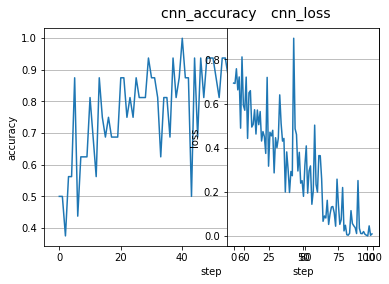

In [7]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# import input_data
# import model
# import https://colab.research.google.com/drive/1tXI1fcv11d1QOCEfWsrOuZyU9k75hjpJ#scrollTo=AykSdWn-nDxb&line=87&uniqifier=1

N_CLASSES = 2  # 猫和狗
IMG_W = 208  # resize图像，太大的话训练时间久
IMG_H = 208
BATCH_SIZE = 16
CAPACITY = 2000
MAX_STEP = 10000  # 一般5K~10k
learning_rate = 0.0001  # 一般小于0.0001

train_dir = '/content/train/train/'
logs_train_dir = '/content/logs/'  # 记录训练过程与保存模型

train, train_label = get_files('/content/train/train/')
train_batch, train_label_batch = get_batch(train,
                                                      train_label,
                                                      IMG_W,
                                                      IMG_H,
                                                      BATCH_SIZE,
                                                      CAPACITY)

train_logits = cnn_inference(train_batch, BATCH_SIZE, N_CLASSES)
train_loss = losses(train_logits, train_label_batch)
train_op = training(train_loss, learning_rate)
train__acc = evaluation(train_logits, train_label_batch)

summary_op = tf.summary.merge_all()  # 这个是log汇总记录

# 可视化为了画折线图
step_list = list(range(100))  # 因为后来的cnn_list加了200个
cnn_list1 = []
cnn_list2 = []
fig = plt.figure()  # 建立可视化图像框
ax = fig.add_subplot(1, 1, 1)  # 子图总行数、列数，位置
ax.yaxis.grid(True)
ax.set_title('cnn_accuracy ', fontsize=14, y=1.02)
ax.set_xlabel('step')
ax.set_ylabel('accuracy')
bx = fig.add_subplot(1, 2, 2)
bx.yaxis.grid(True)
bx.set_title('cnn_loss ', fontsize=14, y=1.02)
bx.set_xlabel('step')
bx.set_ylabel('loss')


# 初始化，如果存在变量则是必不可少的操作
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 产生一个writer来写log文件
    train_writer = tf.summary.FileWriter(logs_train_dir, sess.graph)
    # 产生一个saver来存储训练好的模型
    saver = tf.train.Saver()

    # 队列监控
    # batch训练法用到了队列，不想用队列也可以用placeholder
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    try:
        # 执行MAX_STEP步的训练，一步一个batch
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                break
            # 启动以下操作节点，这里不能用train_op，因为它在第二次迭代是None，会导致session出错，改为_
            _op, tra_loss, tra_acc = sess.run([train_op, train_loss, train__acc])
            # 每隔50步打印一次当前的loss以及acc，同时记录log，写入writer
            if step % 50 == 0:
                print('Step %d, train loss = %.2f, train accuracy = %.2f%%' % (step, tra_loss, tra_acc * 100.0))
                summary_str = sess.run(summary_op)
                train_writer.add_summary(summary_str, step)
            # 每隔100步画个图
            if step % 100 ==0:
                cnn_list1.append(tra_acc)
                cnn_list2.append(tra_loss)
            # 每隔5000步，保存一次训练好的模型
            if step % 5000 == 0 or (step + 1) == MAX_STEP:
                checkpoint_path = os.path.join(logs_train_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

        ax.plot(step_list, cnn_list1)
        bx.plot(step_list, cnn_list2)
        plt.show()

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        coord.request_stop()


#测试1


There are 12500 cats
There are 12500 dogs
Reading checkpoints...
INFO:tensorflow:Restoring parameters from /content/logs/train/model.ckpt-9999
Loading success, global_step is 9999
This is a cat with possibility 0.999998


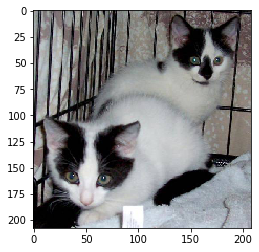

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
# import input_data
# import model
import os
import numpy as np
import tensorflow as tf


def get_one_image(train):
    '''Randomly pick one image from training data
    Return: ndarray
    '''
    n = len(train)
    ind = np.random.randint(0, n)
    img_dir = train[ind]

    image = Image.open(img_dir)
    plt.imshow(image)
    image = image.resize([208, 208])
    image = np.array(image)
    return image


def evaluate_one_image():
    train_dir = '/content/train/train/'
    train, train_label = get_files(train_dir)
    image_array = get_one_image(train)
    # train_dir = '/content/train/train/'
    # logs_train_dir = '/content/logs/train/'  # 记录训练过程与保存模型
    with tf.Graph().as_default():
        BATCH_SIZE = 1
        N_CLASSES = 2

        image = tf.cast(image_array, tf.float32)
        image = tf.image.per_image_standardization(image)
        image = tf.reshape(image, [1, 208, 208, 3])
        logit = cnn_inference(image, BATCH_SIZE, N_CLASSES)

        logit = tf.nn.softmax(logit)

        x = tf.placeholder(tf.float32, shape=[208, 208, 3])

        # you need to change the directories to yours.
        logs_train_dir = '/content/logs/'

        saver = tf.train.Saver()

        with tf.Session() as sess:

            print("Reading checkpoints...")
            ckpt = tf.train.get_checkpoint_state(logs_train_dir)
            if ckpt and ckpt.model_checkpoint_path:
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('Loading success, global_step is %s' % global_step)
            else:
                print('No checkpoint file found')

            prediction = sess.run(logit, feed_dict={x: image_array})
            max_index = np.argmax(prediction)
            if max_index == 0:
                print('This is a cat with possibility %.6f' % prediction[:, 0])
            else:
                print('This is a dog with possibility %.6f' % prediction[:, 1])
    plt.imshow(image_array)
    plt.show()


evaluate_one_image()

#测试2

There are 12500 cats
There are 12500 dogs
25000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from /content/logs/train/model.ckpt-9999
Loading success, global_step is 9999
This is a cat with possibility 0.993204


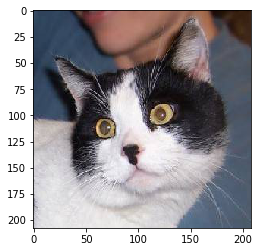

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
# import input_data
# import model
import os
import numpy as np
import tensorflow as tf


def get_one_image(train):
    '''Randomly pick one image from training data
    Return: ndarray
    '''
    n = len(train)
    print(n)
    ind = np.random.randint(0, n)
    img_dir = train[ind]

    image = Image.open(img_dir)
    plt.imshow(image)
    image = image.resize([208, 208])
    image = np.array(image)
    return image


def evaluate_one_image():
    '''Test one image against the saved models and parameters
    '''

    # you need to change the directories to yours.
    # train_dir = 'D:/python/deep-learning/CatVsDog/Project/test_image/'
    # train_dir = '/content/train/train/'
    # logs_train_dir = '/content/logs/train/'  # 记录训练过程与保存模型
    train_dir = '/content/train/train/'
    train, train_label = get_files(train_dir)
    image_array = get_one_image(train)

    with tf.Graph().as_default():
        BATCH_SIZE = 1
        N_CLASSES = 2

        image = tf.cast(image_array, tf.float32)
        image = tf.image.per_image_standardization(image)
        image = tf.reshape(image, [1, 208, 208, 3])
        logit = cnn_inference(image, BATCH_SIZE, N_CLASSES)

        logit = tf.nn.softmax(logit)

        x = tf.placeholder(tf.float32, shape=[208, 208, 3])

        # you need to change the directories to yours.
        logs_train_dir = '/content/logs/train/'

        saver = tf.train.Saver()

        with tf.Session() as sess:

            print("Reading checkpoints...")
            ckpt = tf.train.get_checkpoint_state(logs_train_dir)
            if ckpt and ckpt.model_checkpoint_path:
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('Loading success, global_step is %s' % global_step)
            else:
                print('No checkpoint file found')

            prediction = sess.run(logit, feed_dict={x: image_array})
            max_index = np.argmax(prediction)
            if max_index == 0:
                print('This is a cat with possibility %.6f' % prediction[:, 0])
            else:
                print('This is a dog with possibility %.6f' % prediction[:, 1])
    plt.imshow(image_array)
    plt.show()


evaluate_one_image()

#测试3

There are 12500 cats
There are 12500 dogs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 0


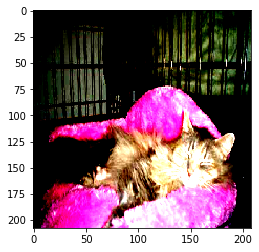

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1


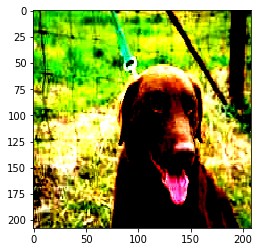

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 0


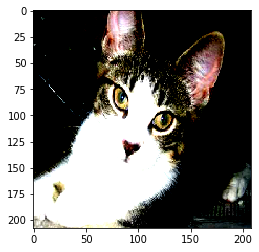

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1


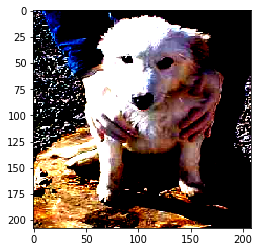

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 0


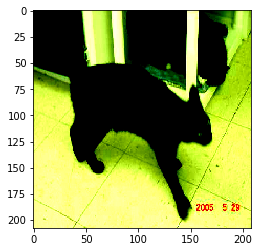

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1


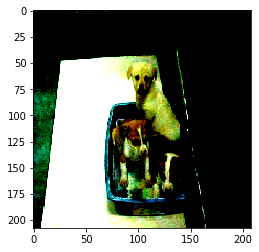

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1


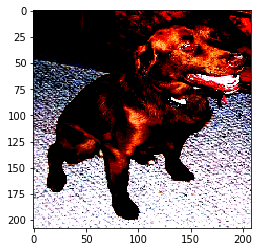

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1


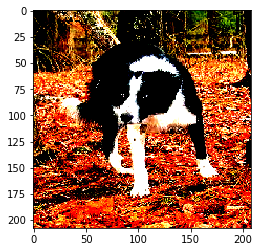

In [9]:
# TEST
# To test the generated batches of images
# When training the model, Do comment the following codes

import math
import matplotlib.pyplot as plt

BATCH_SIZE = 8
CAPACITY = 256
IMG_W = 208
IMG_H = 208

train_dir = '/content/train/train/'
ratio = 0.2
tra_images, tra_labels, val_images, val_labels = get_files_havevali(train_dir, ratio)
tra_image_batch, tra_label_batch = get_batch(tra_images, tra_labels, IMG_W, IMG_H, BATCH_SIZE, CAPACITY)



with tf.Session() as sess:
   i = 0
   coord = tf.train.Coordinator()
   threads = tf.train.start_queue_runners(coord=coord)

   try:
       while not coord.should_stop() and i<1:

           img, label = sess.run([tra_image_batch, tra_label_batch])

           # just test one batch
           for j in np.arange(BATCH_SIZE):
               print('label: %d' %label[j])
               plt.imshow(img[j,:,:,:])
               plt.show()
           i+=1

   except tf.errors.OutOfRangeError:
       print('done!')
   finally:
       coord.request_stop()
   coord.join(threads)


#创建目录

In [0]:
!mkdir /content/data

加载数据

In [3]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"incentercenter","key":"733d5d96ccf60aa2354d0d4567666388"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d biaiscience/dogs-vs-cats 

 99% 810M/817M [00:16<00:00, 28.4MB/s]
100% 817M/817M [00:16<00:00, 51.8MB/s]


In [4]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: test/test/1.jpg         
  inflating: test/test/10.jpg        
  inflating: test/test/100.jpg       
  inflating: test/test/1000.jpg      
  inflating: test/test/10000.jpg     
  inflating: test/test/10001.jpg     
  inflating: test/test/10002.jpg     
  inflating: test/test/10003.jpg     
  inflating: test/test/10004.jpg     
  inflating: test/test/10005.jpg     
  inflating: test/test/10006.jpg     
  inflating: test/test/10007.jpg     
  inflating: test/test/10008.jpg     
  inflating: test/test/10009.jpg     
  inflating: test/test/1001.jpg      
  inflating: test/test/10010.jpg     
  inflating: test/test/10011.jpg     
  inflating: test/test/10012.jpg     
  inflating: test/test/10013.jpg     
  inflating: test/test/10014.jpg     
  inflating: test/test/10015.jpg     
  inflating: test/test/10016.jpg     
  inflating: test/test/10017.jpg     
  inflating: test/test/10018.jpg     
  inflating: test/test/10019.jpg     
  inflating: test/test/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir logs
!mkdir train_record